# **10x Visium colon metabolic Hotspot robustness analysis**

This notebook reproduces the figures present in Fig S8.

In [2]:
import harreman
import os
import json
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from scipy.stats import pearsonr, wilcoxon, mannwhitneyu, ranksums, spearmanr
import random
import scipy.stats as stats
from sklearn import linear_model
from scipy.stats import hypergeom, zscore, norm
from statsmodels.stats.multitest import multipletests
from plotnine import *
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import fcluster
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

## Load dataset

Load the AnnData file and create the Hotspot object.

In [2]:
adata = ad.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_unrolled_adata.h5ad'))

Filter out genes expressed in less than 50 spots per sample

In [3]:
sample_col = 'cond'
n_genes_expr = 50
genes_to_keep = np.zeros(adata.shape[1], dtype=bool)

for sample in adata.obs[sample_col].unique():
    adata_sample = adata[adata.obs[sample_col] == sample]
    expressed = np.array((adata_sample.X > 0).sum(axis=0)).flatten()
    genes_to_keep |= expressed >= n_genes_expr

adata = adata[:, genes_to_keep]

## Autocorrelation

In [4]:
n_neighbors_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ref_value = 5

In [5]:
def autocorrelation_robustness_pipeline(adata, n_neighbors):
    
    harreman.tl.compute_knn_graph(adata,
                           compute_neighbors_on_key="spatial_unrolled",
                           n_neighbors=n_neighbors,
                           weighted_graph=False,
                           sample_key='cond')
    
    harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='danb', species='mouse', use_metabolic_genes=True)
    
    gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
    
    return gene_autocorrelation_results

In [6]:
gene_autocorrelation_results_dict = {}
for n_neighbors in n_neighbors_values:
    gene_autocorrelation_results = autocorrelation_robustness_pipeline(adata, n_neighbors)
    gene_autocorrelation_results_dict[n_neighbors] = gene_autocorrelation_results

100%|██████████| 2/2 [00:00<00:00, 25.02it/s]


In [7]:
for key, df in gene_autocorrelation_results_dict.items():
    df["Rank"] = range(1, len(df)+1)

In [8]:
C_df = pd.concat(
    {key: df["C"] for key, df in gene_autocorrelation_results_dict.items()}, axis=1
)

C_diff_df = C_df.subtract(C_df.loc[:, ref_value], axis=0)

C_rank_df = pd.concat(
    {key: df["Rank"] for key, df in gene_autocorrelation_results_dict.items()}, axis=1
)

In [9]:
C_diff_melt = C_diff_df.reset_index().melt(
    id_vars="Gene", 
    var_name="n_neighbors", 
    value_name="Value"
)

C_rank_melt = C_rank_df.reset_index().melt(
    id_vars="Gene", 
    var_name="n_neighbors", 
    value_name="Value"
)

In [10]:
C_diff_melt['Rank'] = C_rank_melt['Value']

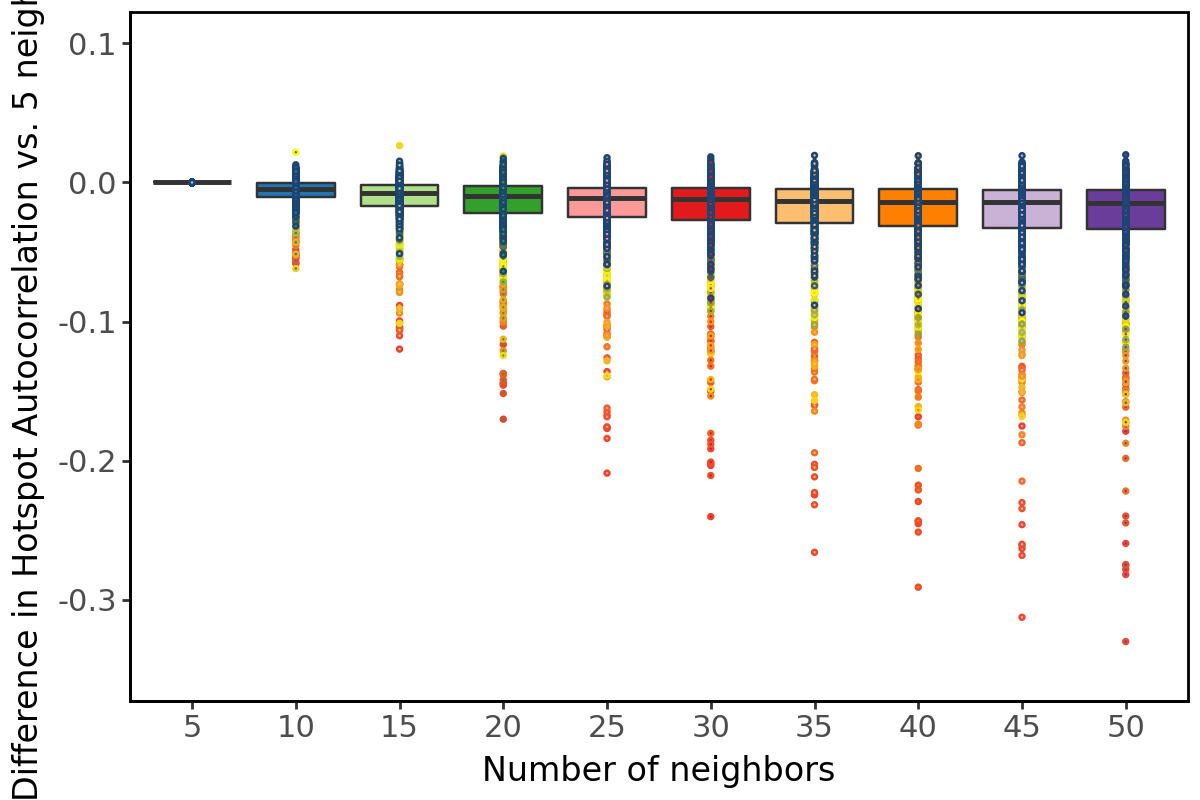

In [11]:
fig = (
ggplot(data=C_diff_melt, mapping=aes(x="n_neighbors", y="Value", fill="n_neighbors"))
+ geom_boxplot(outlier_shape="")
+ geom_point(aes(color="Rank"), size=0.5, data=C_diff_melt, show_legend=True)
+ scale_fill_manual(values=["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A"])
+ scale_color_gradientn(
        colors=["#ED3E30", "yellow", "#1C4573"],  # Define multiple colors
        limits=(0, 200))
+ xlab('Number of neighbors')
+ ylab('Difference in Hotspot Autocorrelation vs. 5 neighbors')
+ ylim(-0.35, 0.1)
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'autocor_robustness_box_plot_unrolled.svg'), format='svg')
# fig.save(os.path.join(PLOTS_PATH, 'autocor_robustness_box_plot_leg_unrolled.svg'), format='svg')
fig

### Pairwise correlation (number of neighbors)

In [12]:
n_neighbors_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ref_value = 5

In [13]:
def pairwise_correlation_robustness_pipeline(adata, n_neighbors):
    
    harreman.tl.compute_knn_graph(adata,
                           compute_neighbors_on_key="spatial_unrolled",
                           n_neighbors=n_neighbors,
                           weighted_graph=False,
                           sample_key='cond')
        
    harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='danb', species='mouse', use_metabolic_genes=True)
    
    gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
    genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index
    
    harreman.hs.compute_local_correlation(adata, genes=genes)
    
    harreman.hs.create_modules(adata, min_gene_threshold=20)
    
    harreman.hs.calculate_module_scores(adata)
    
    return adata.uns['gene_modules'], adata.obsm['module_scores']

In [14]:
def pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref):
    
    jaccard_sim_matrix = np.zeros((len(gene_modules.keys()), len(gene_modules_ref.keys())))
    for i in range(len(gene_modules.keys())):
        for j in range(len(gene_modules_ref.keys())):
            key_i = list(gene_modules.keys())[i]
            key_j = list(gene_modules_ref.keys())[j]
            a = gene_modules[key_i]
            b = gene_modules_ref[key_j]
            jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
    jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=gene_modules.keys(), columns=gene_modules_ref.keys())
    
    correlation_matrix = pd.DataFrame(
        [[module_scores[col1].corr(module_scores_ref[col2]) for col2 in module_scores_ref.columns] for col1 in module_scores.columns],
        index=module_scores.columns,
        columns=module_scores_ref.columns
    )
    
    similarity_matrix = (jaccard_sim_matrix_df + correlation_matrix)/2
    max_similarity = similarity_matrix.idxmax()
    
    correlation_values = [correlation_matrix.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    jaccard_values = [jaccard_sim_matrix_df.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    
    return correlation_values, jaccard_values

In [15]:
pairwise_correlation_gene_modules_dict = {}
pairwise_correlation_module_scores_dict = {}
for n_neighbors in n_neighbors_values:
    print(n_neighbors)
    gene_modules, module_scores = pairwise_correlation_robustness_pipeline(adata, n_neighbors)
    pairwise_correlation_gene_modules_dict[n_neighbors] = gene_modules
    pairwise_correlation_module_scores_dict[n_neighbors] = module_scores

5


100%|██████████| 2/2 [00:00<00:00, 113.11it/s]


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


10


100%|██████████| 8/8 [00:01<00:00,  5.92it/s]


15


100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


20


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


25


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


30


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


35


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


40


100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


45


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


50


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


In [16]:
correlation_values_dict = {}
jaccard_values_dict = {}
n_modules_dict = {}
for n_neighbors in n_neighbors_values:
    gene_modules = pairwise_correlation_gene_modules_dict[n_neighbors]
    module_scores = pairwise_correlation_module_scores_dict[n_neighbors]
    gene_modules_ref = pairwise_correlation_gene_modules_dict[ref_value]
    module_scores_ref = pairwise_correlation_module_scores_dict[ref_value]
    correlation_values, jaccard_values = pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref)
    correlation_values_dict[n_neighbors] = correlation_values
    jaccard_values_dict[n_neighbors] = jaccard_values
    n_modules_dict[n_neighbors] = len(gene_modules.keys())

In [17]:
n_modules_df = pd.DataFrame.from_dict(n_modules_dict.items()).rename(columns={0: 'n_neighbors', 1: 'n_modules'})

In [18]:
jaccard_values_df = pd.concat(
    {key: pd.Series(list) for key, list in jaccard_values_dict.items()}, axis=1
).melt( 
    var_name="n_neighbors", 
    value_name="Value"
)

correlation_values_df = pd.concat(
    {key: pd.Series(list) for key, list in correlation_values_dict.items()}, axis=1
).melt( 
    var_name="n_neighbors", 
    value_name="Value"
)

In [19]:
jaccard_values_df["n_neighbors"] = jaccard_values_df["n_neighbors"].astype('category')
correlation_values_df["n_neighbors"] = correlation_values_df["n_neighbors"].astype('category')
n_modules_df["n_neighbors"] = n_modules_df["n_neighbors"].astype('category')

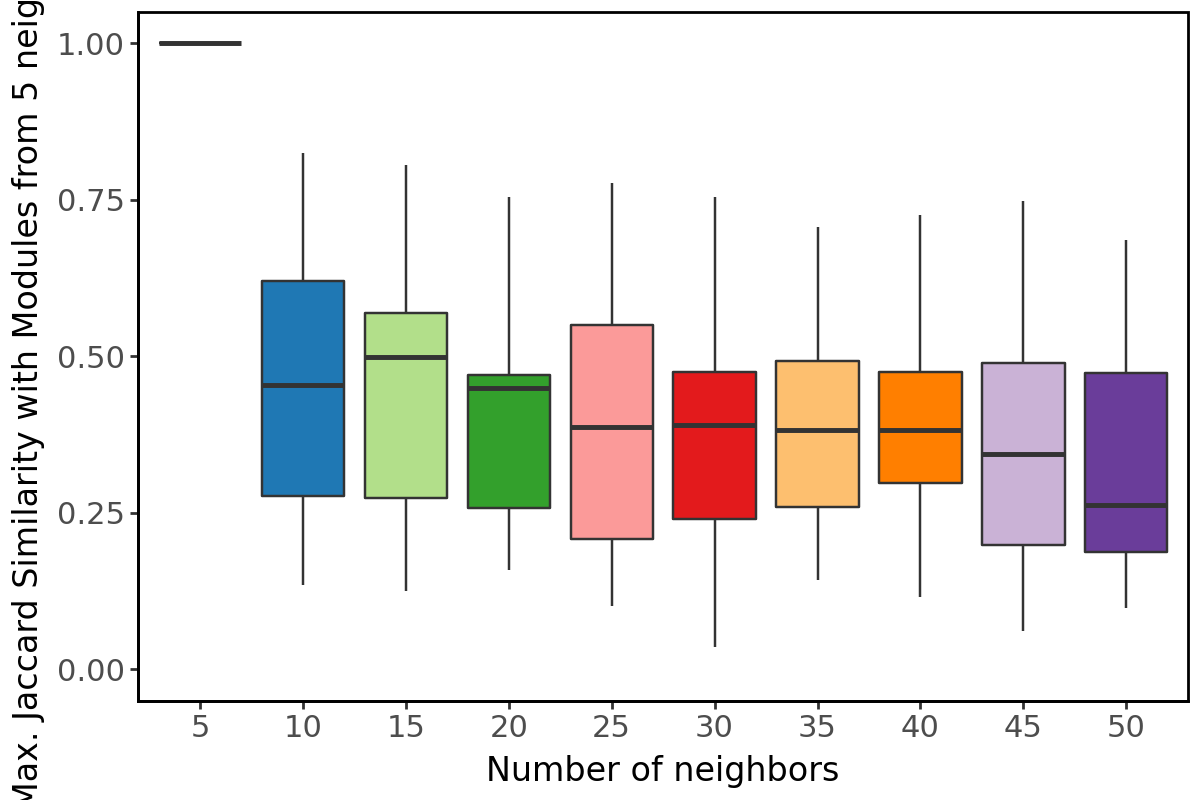

In [20]:
fig = (
ggplot(data=jaccard_values_df, mapping=aes(x="n_neighbors", y="Value", fill="n_neighbors")) 
# + geom_boxplot(width=0.8, outlier_shape="")
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
# + geom_boxplot(outlier_shape=None)
# + geom_point(size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A"])
+ xlab('Number of neighbors')
+ ylab('Max. Jaccard Similarity with Modules from 5 neighbors')
+ theme_classic() 
+ ylim(0,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_jaccard_n_neighbors_box_plot_unrolled_no_points.svg'), format='svg')
fig

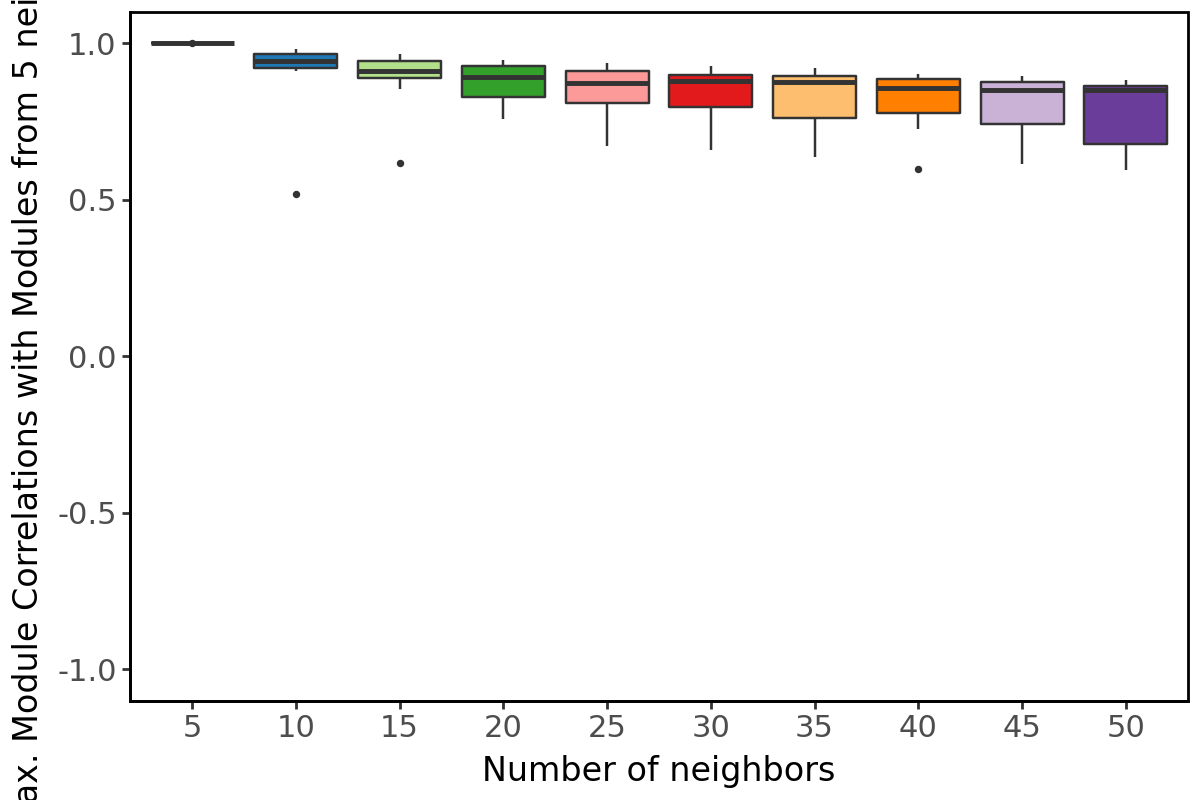

In [21]:
fig = (
ggplot(data=correlation_values_df, mapping=aes(x="n_neighbors", y="Value", fill="n_neighbors")) 
# + geom_boxplot(width=0.8, outlier_shape="")
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A"])
+ xlab('Number of neighbors')
+ ylab('Max. Module Correlations with Modules from 5 neighbors')
+ theme_classic() 
+ ylim(-1,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_max_cor_n_neighbors_box_plot_unrolled_no_points.svg'), format='svg')
fig

In [22]:
y_ticks = range(0, n_modules_df['n_modules'].max() + 2, 4)

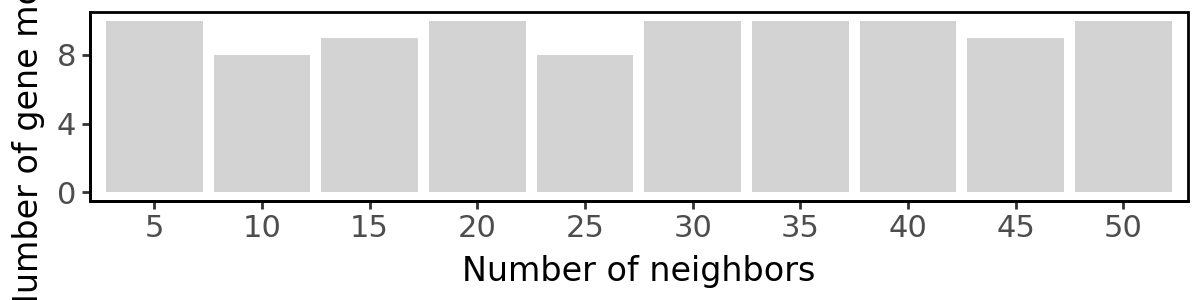

In [23]:
fig = (
ggplot(data=n_modules_df, mapping=aes(x="n_neighbors", y="n_modules")) 
+ geom_bar(stat='identity', fill='lightgrey') 
+ xlab('Number of neighbors')
+ ylab('Number of gene modules')
+ scale_y_continuous(breaks=y_ticks)
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 1.5))
)
# fig.save(os.path.join(PLOTS_PATH, 'n_modules_n_neighbors_bar_plot_unrolled.svg'), format='svg')
fig

### Pairwise correlation (min_gene_threshold)

In [24]:
min_gene_threshold_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]
ref_value = 20

In [25]:
def pairwise_correlation_robustness_pipeline(adata, min_gene_threshold):
    
    harreman.tl.compute_knn_graph(adata,
                           compute_neighbors_on_key="spatial_unrolled",
                           n_neighbors=5,
                           weighted_graph=False,
                           sample_key='cond')
        
    harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='danb', species='mouse', use_metabolic_genes=True)
    
    gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
    genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index
    
    harreman.hs.compute_local_correlation(adata, genes=genes)
    
    harreman.hs.create_modules(adata, min_gene_threshold=min_gene_threshold)
    
    harreman.hs.calculate_module_scores(adata)
    
    return adata.uns['gene_modules'], adata.obsm['module_scores']

In [26]:
def pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref):
    
    jaccard_sim_matrix = np.zeros((len(gene_modules.keys()), len(gene_modules_ref.keys())))
    for i in range(len(gene_modules.keys())):
        for j in range(len(gene_modules_ref.keys())):
            key_i = list(gene_modules.keys())[i]
            key_j = list(gene_modules_ref.keys())[j]
            a = gene_modules[key_i]
            b = gene_modules_ref[key_j]
            jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
    jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=gene_modules.keys(), columns=gene_modules_ref.keys())
    
    correlation_matrix = pd.DataFrame(
        [[module_scores[col1].corr(module_scores_ref[col2]) for col2 in module_scores_ref.columns] for col1 in module_scores.columns],
        index=module_scores.columns,
        columns=module_scores_ref.columns
    )
    
    similarity_matrix = (jaccard_sim_matrix_df + correlation_matrix)/2
    max_similarity = similarity_matrix.idxmax()
    
    correlation_values = [correlation_matrix.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    jaccard_values = [jaccard_sim_matrix_df.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    
    return correlation_values, jaccard_values

In [27]:
pairwise_correlation_gene_modules_dict = {}
pairwise_correlation_module_scores_dict = {}
for min_gene_threshold in min_gene_threshold_values:
    print(min_gene_threshold)
    gene_modules, module_scores = pairwise_correlation_robustness_pipeline(adata, min_gene_threshold)
    pairwise_correlation_gene_modules_dict[min_gene_threshold] = gene_modules
    pairwise_correlation_module_scores_dict[min_gene_threshold] = module_scores

10


100%|██████████| 15/15 [00:02<00:00,  6.13it/s]


15


100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


20


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


25


100%|██████████| 9/9 [00:01<00:00,  7.51it/s]


30


100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


35


100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


40


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


45


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


50


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


In [28]:
correlation_values_dict = {}
jaccard_values_dict = {}
n_modules_dict = {}
for min_gene_threshold in min_gene_threshold_values:
    gene_modules = pairwise_correlation_gene_modules_dict[min_gene_threshold]
    module_scores = pairwise_correlation_module_scores_dict[min_gene_threshold]
    gene_modules_ref = pairwise_correlation_gene_modules_dict[ref_value]
    module_scores_ref = pairwise_correlation_module_scores_dict[ref_value]
    correlation_values, jaccard_values = pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref)
    correlation_values_dict[min_gene_threshold] = correlation_values
    jaccard_values_dict[min_gene_threshold] = jaccard_values
    n_modules_dict[min_gene_threshold] = len(gene_modules.keys())

In [29]:
n_modules_df = pd.DataFrame.from_dict(n_modules_dict.items()).rename(columns={0: 'ngenes', 1: 'n_modules'})

In [30]:
jaccard_values_df = pd.concat(
    {key: pd.Series(list) for key, list in jaccard_values_dict.items()}, axis=1
).melt( 
    var_name="ngenes", 
    value_name="Value"
)

correlation_values_df = pd.concat(
    {key: pd.Series(list) for key, list in correlation_values_dict.items()}, axis=1
).melt( 
    var_name="ngenes", 
    value_name="Value"
)

In [31]:
jaccard_values_df["ngenes"] = jaccard_values_df["ngenes"].astype('category')
correlation_values_df["ngenes"] = correlation_values_df["ngenes"].astype('category')
n_modules_df["ngenes"] = n_modules_df["ngenes"].astype('category')

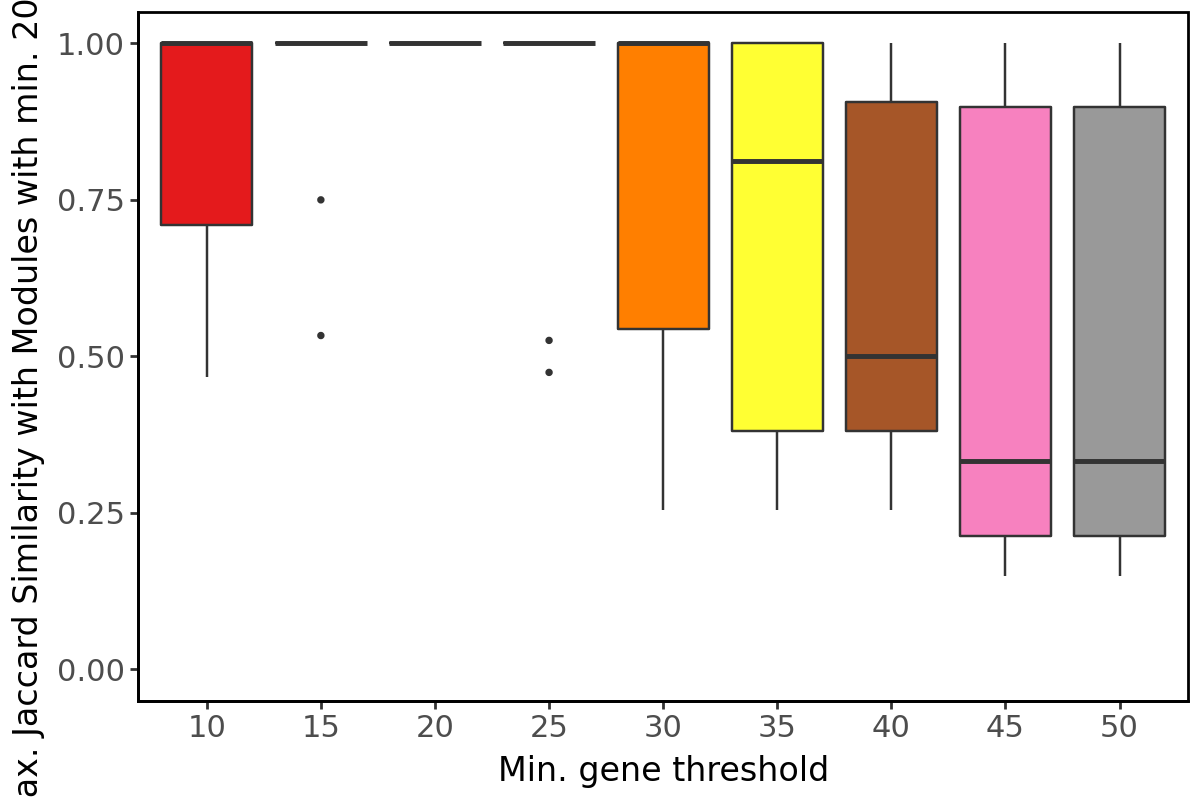

In [32]:
fig = (
ggplot(data=jaccard_values_df, mapping=aes(x="ngenes", y="Value", fill="ngenes")) 
# + geom_boxplot(width=0.8, outlier_shape="")
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "#999999"])
+ xlab('Min. gene threshold')
+ ylab('Max. Jaccard Similarity with Modules with min. 20 genes')
+ theme_classic() 
+ ylim(0,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_jaccard_min_gene_box_plot_unrolled_no_points.svg'), format='svg')
fig

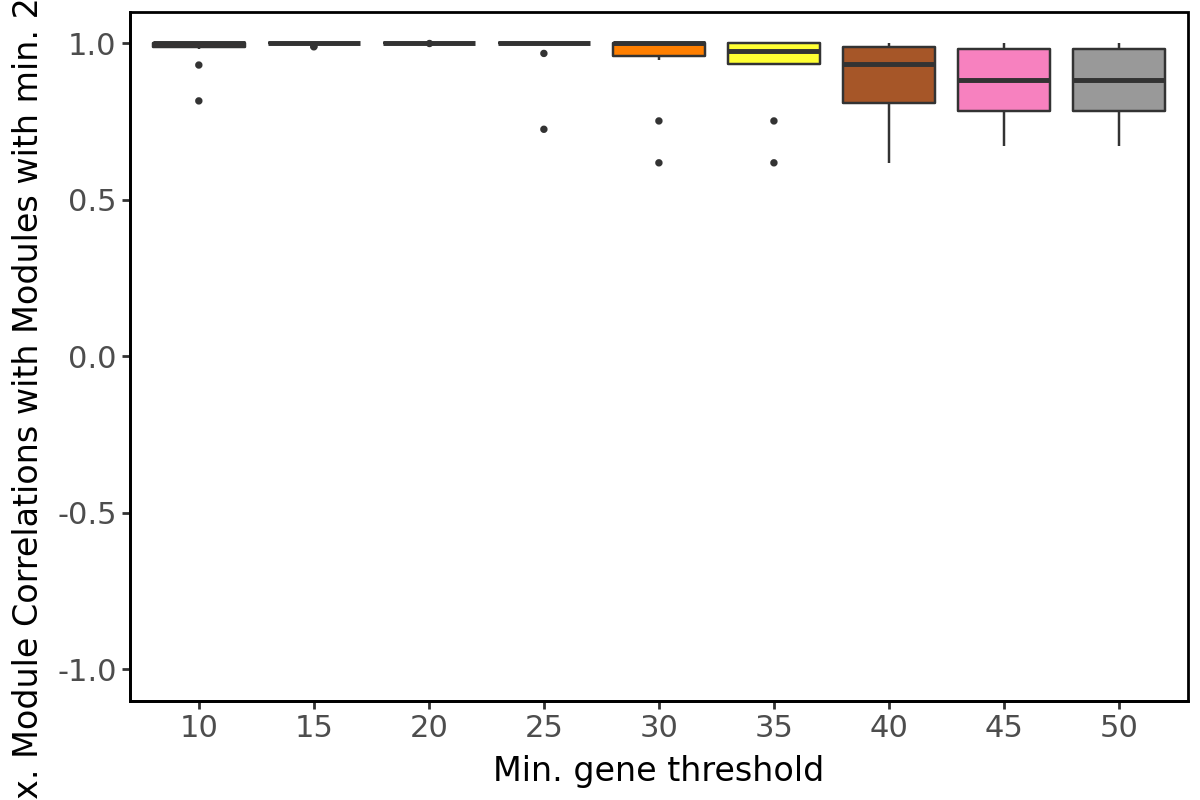

In [33]:
fig = (
ggplot(data=correlation_values_df, mapping=aes(x="ngenes", y="Value", fill="ngenes")) 
# + geom_boxplot(width=0.8, outlier_shape="")
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "#999999"])
+ xlab('Min. gene threshold')
+ ylab('Max. Module Correlations with Modules with min. 20 genes')
+ theme_classic() 
+ ylim(-1,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_max_cor_min_gene_box_plot_unrolled_no_points.svg'), format='svg')
fig

In [34]:
y_ticks = range(0, n_modules_df['n_modules'].max() + 2, 4)

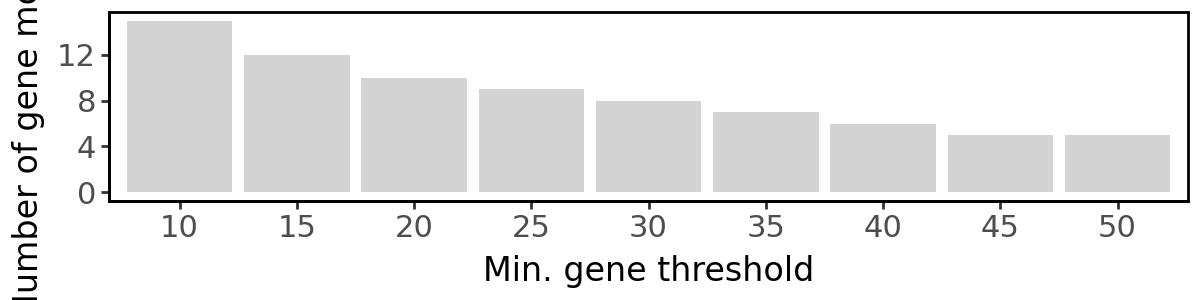

In [35]:
fig = (
ggplot(data=n_modules_df, mapping=aes(x="ngenes", y="n_modules")) 
+ geom_bar(stat='identity', fill='lightgrey') 
+ xlab('Min. gene threshold')
+ ylab('Number of gene modules')
+ scale_y_continuous(breaks=y_ticks)
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 1.5))
)
# fig.save(os.path.join(PLOTS_PATH, 'n_modules_min_gene_bar_plot_unrolled.svg'), format='svg')
fig

## Comparison between the Hotspot pairwise correlation and Pearson correlation

In [3]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_Metabolic_Hotspot_unrolled.h5ad'))

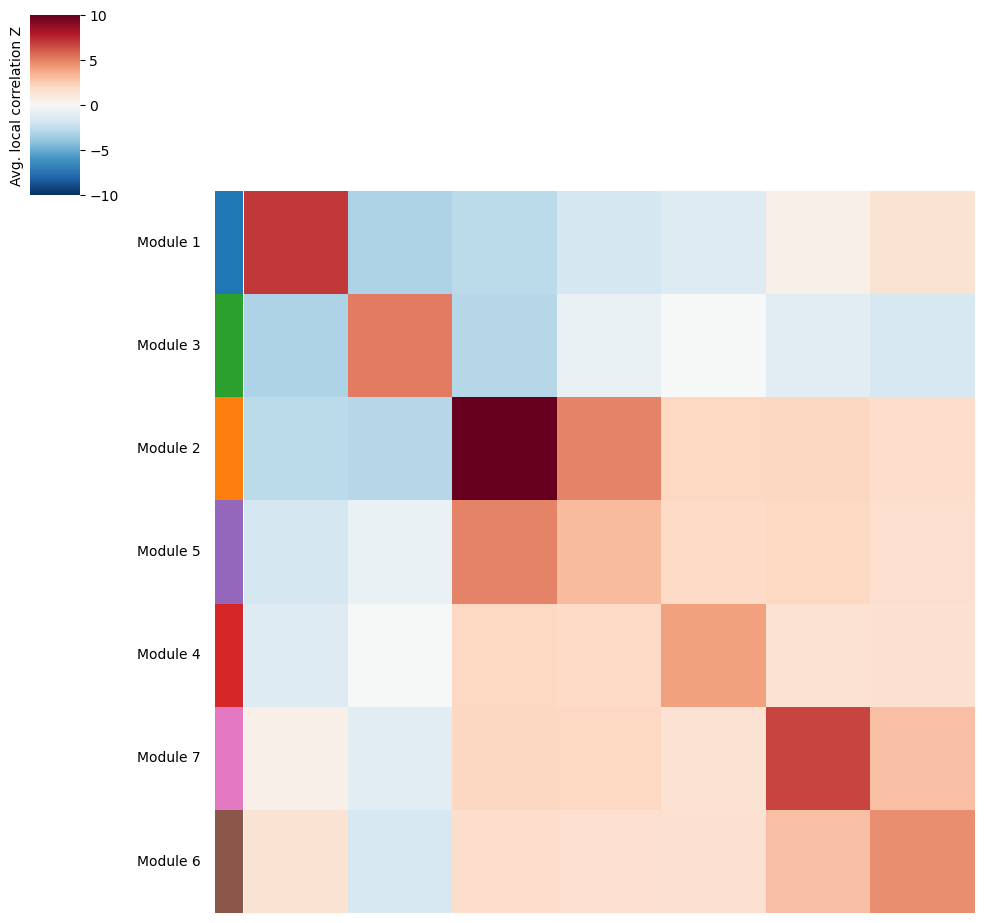

In [4]:
harreman.pl.average_local_correlation_plot(adata, col_cluster=False, row_cluster=False, show=False, use_super_modules=True)
# plt.savefig(os.path.join(PLOTS_PATH, 'avg_local_correlation_plot_sm.svg'))

In [5]:
def danb_model(gene_counts, umi_counts):

    tj = gene_counts.sum()
    tis = umi_counts
    total = tis.sum()

    N = gene_counts.size

    min_size = 10**(-10)

    mu = tj*tis/total
    vv = (gene_counts - mu).var()*(N/(N-1))
    my_rowvar = vv

    size = ((tj**2) / total) * ((tis**2).sum() / total) / ((N-1)*my_rowvar-tj)

    if size < 0:    # Can't have negative dispersion
        size = 1e9

    if size < min_size and size >= 0:
        size = min_size

    var = mu*(1+mu/size)
    x2 = var+mu**2

    return mu, var, x2

In [6]:
def create_centered_counts_row(vals_x, model, num_umi):
    mu_x, var_x, x2_x = danb_model(
        vals_x, num_umi)

    var_x[var_x == 0] = 1
    out_x = (vals_x-mu_x)/(var_x**0.5)
    out_x[out_x == 0] = 0

    return out_x

In [7]:
def create_centered_counts(counts, model, num_umi):
    """
    Creates a matrix of centered/standardized counts given
    the selected statistical model
    """
    out = np.zeros_like(counts, dtype='double')

    for i in range(out.shape[0]):

        vals_x = counts[i]

        out_x = create_centered_counts_row(
            vals_x, model, num_umi)

        out[i] = out_x

    return out

In [8]:
from scipy.sparse import issparse

In [9]:
gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index

In [10]:
counts = adata[:, genes].layers['counts']
counts = counts.transpose()

is_sparse = issparse(counts)

if not is_sparse:
    counts = np.asarray(counts)

counts = counts.A if is_sparse else counts

In [11]:
num_umi = adata.uns['umi_counts']

In [12]:
sample_key = adata.uns['sample_key']
for sample in adata.obs[sample_key].unique().tolist():
    subset = np.where(adata.obs[sample_key] == sample)[0]
    counts[:,subset] = create_centered_counts(counts[:,subset], 'danb', num_umi[subset])

In [13]:
pearson_cor_matrix = pd.DataFrame(np.corrcoef(counts), index=genes, columns=genes)

In [14]:
from scipy.cluster.hierarchy import leaves_list

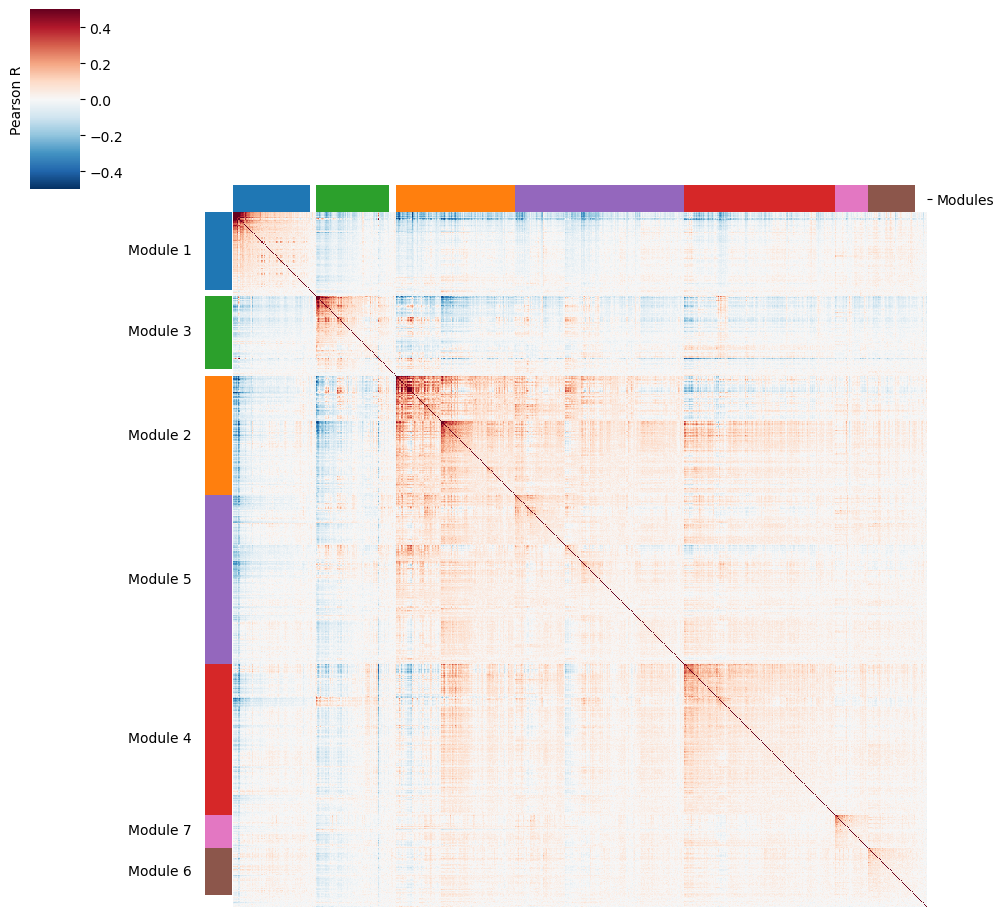

In [15]:
mod_cmap='tab10'
vmin=-0.5
vmax=0.5
z_cmap='RdBu_r'
yticklabels=False
use_super_modules=True
row_colors=True,
col_colors=None,
show=True,

local_correlation_z = pearson_cor_matrix
modules = adata.uns["super_modules"] if use_super_modules else adata.uns["modules"]
linkage = adata.uns["linkage"]

row_colors = None
colors = list(plt.get_cmap(mod_cmap).colors)
module_colors = {i: colors[(i-1) % len(colors)] for i in modules.unique()}
module_colors[-1] = '#ffffff'

modules = modules[local_correlation_z.index]

row_colors1 = pd.Series(
    [module_colors[i] for i in modules],
    index=local_correlation_z.index,
)

row_colors = pd.DataFrame({
    "Modules": row_colors1,
})

col_colors = row_colors if col_colors is True else None

cm = sns.clustermap(
    local_correlation_z,
    row_linkage=linkage,
    col_linkage=linkage,
    vmin=vmin,
    vmax=vmax,
    cmap=z_cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=row_colors,
    col_colors=row_colors,
    rasterized=True,
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
# Add 'module X' annotations
ii = leaves_list(linkage)

mod_reordered = modules.iloc[ii]

adata.uns['mod_reordered'] = [mod for mod in mod_reordered.unique() if mod != -1]

mod_map = {}
y = np.arange(modules.size)

for x in mod_reordered.unique():
    if x == -1:
        continue

    mod_map[x] = y[mod_reordered == x].mean()

plt.sca(cm.ax_row_colors)
for mod, mod_y in mod_map.items():
    plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                horizontalalignment='right',
                verticalalignment='center')
plt.xticks([])

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Pearson R')
min_aa.yaxis.set_label_position("left")

if show:
    plt.show()

# plt.savefig(os.path.join(PLOTS_PATH, 'pearson_correlation_plot.svg'))

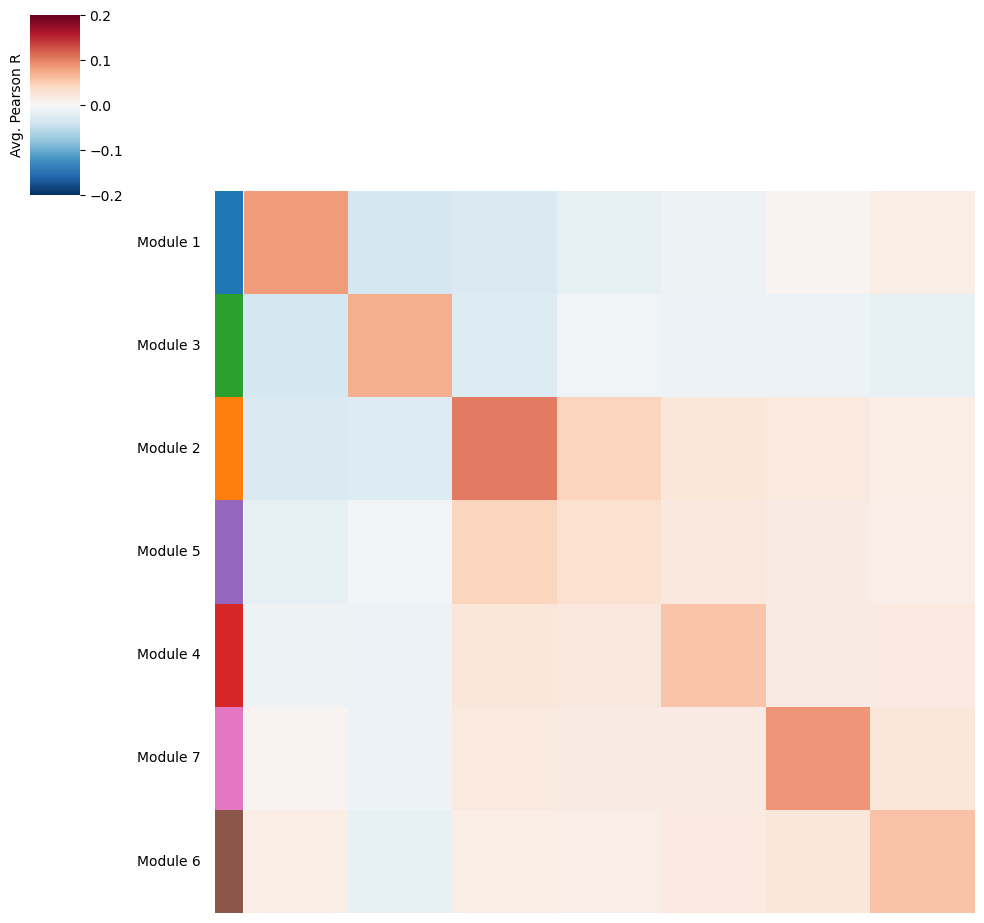

In [16]:
mod_cmap='tab10'
vmin=-0.2
vmax=0.2
cor_cmap='RdBu_r'
yticklabels=False
row_cluster=False
col_cluster=False
use_super_modules=True
show=True

local_correlation_z = pearson_cor_matrix
modules = adata.uns["super_modules"] if use_super_modules else adata.uns["modules"]

avg_local_correlation_z = local_correlation_z.copy()
avg_local_correlation_z['module_row'] = modules
avg_local_correlation_z = avg_local_correlation_z.set_index('module_row', append=True)
avg_local_correlation_z.columns = pd.MultiIndex.from_arrays([modules[avg_local_correlation_z.columns].values, avg_local_correlation_z.columns])

avg_local_correlation_z = avg_local_correlation_z.groupby(level=1).mean().groupby(level=0, axis=1).mean()
avg_local_correlation_z = avg_local_correlation_z.loc[avg_local_correlation_z.index != -1, avg_local_correlation_z.columns != -1]
mod_reordered = adata.uns['mod_reordered']
avg_local_correlation_z = avg_local_correlation_z.loc[mod_reordered, mod_reordered]

row_colors = None
colors = list(plt.get_cmap(mod_cmap).colors)
module_colors = {i: colors[(i-1) % len(colors)] for i in modules.unique()}
module_colors[-1] = '#ffffff'

row_colors = pd.DataFrame({
    "Modules": module_colors,
})

cm = sns.clustermap(
    avg_local_correlation_z,
    vmin=vmin,
    vmax=vmax,
    cmap=cor_cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=row_colors,
    rasterized=True,
    row_cluster=row_cluster,
    col_cluster=col_cluster,
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()

if row_cluster:
    reordered_indices = cm.dendrogram_row.reordered_ind
    mod_reordered = [avg_local_correlation_z.index[i] for i in reordered_indices]

mod_map = {}
y = np.arange(len(mod_reordered))

for x in mod_reordered:
    if x == -1:
        continue

    mod_map[x] = y[mod_reordered == x].mean() + 0.5

plt.sca(cm.ax_row_colors)
for mod, mod_y in mod_map.items():
    plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                horizontalalignment='right',
                verticalalignment='center')
plt.xticks([])

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Avg. Pearson R')
min_aa.yaxis.set_label_position("left")

if show:
    plt.show()

# plt.savefig(os.path.join(PLOTS_PATH, 'avg_pearson_correlation_plot.svg'))

In [17]:
np.fill_diagonal(pearson_cor_matrix.values, 0)

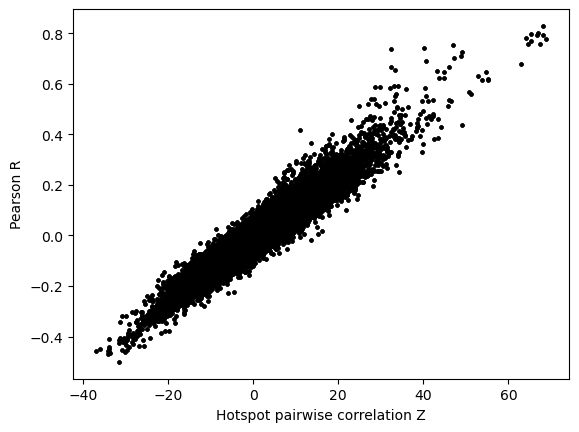

In [18]:
# global consistency
x = adata.uns['lc_zs'].values.flatten()
y = pearson_cor_matrix.values.flatten()
plt.scatter(x, y, s=5, color='black')
# plt.ylim(-0.1, 0.1)
plt.xlabel('Hotspot pairwise correlation Z')
plt.ylabel('Pearson R')
plt.show()
# plt.savefig(os.path.join(PLOTS_PATH, 'pearson_lc_scatter_plot.png'))